In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import crested

In [2]:
# bigwigs, regions = crested.get_dataset("mouse_cortex_bigwig")
bigwigs = "/staging/leuven/stg_00002/lcb/lmahieu/data/biccn/mouse_cortex/bigwigs"
regions = "/staging/leuven/stg_00002/lcb/lmahieu/data/biccn/mouse_cortex/consensus_peaks_biccn.bed"

In [3]:
print(bigwigs)
print(regions)

/home/luna.kuleuven.be/u0166574/.cache/crested/data/mouse_biccn/bigwigs.tar.gz.untar
/home/luna.kuleuven.be/u0166574/.cache/crested/data/mouse_biccn/consensus_peaks_biccn.bed


In [4]:
adata = crested.import_bigwigs(bigwigs, regions)

2024-11-19T10:48:34.931403+0100 WARNING Chromsizes file not provided. Will not check if regions are within chromosomes
2024-11-19T10:48:35.832092+0100 INFO Extracting values from 19 bigWig files...


## Preprocess

In [31]:
crested.pp.filter_regions_on_specificity(adata, gini_std_threshold=2.0)

2024-11-19T10:20:56.407967+0100 INFO After specificity filtering, kept 14337 out of 546993 regions.


In [6]:
crested.pp.train_val_test_split(adata, strategy="region", val_size=0.1, test_size=0.1)

In [7]:
crested.pp.change_regions_width(adata, width=500)

2024-11-19T10:14:31.912120+0100 WARNING Chromsizes file not provided. Will not check if regions are within chromosomes


## Train tmp model

In [8]:
genome_path = "/home/luna.kuleuven.be/u0166574/.local/share/genomes/mm10/mm10.fa"

In [9]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file=genome_path,
    always_reverse_complement=False,
    batch_size=32,
)

In [10]:
model_arch = crested.tl.zoo.simple_convnet(
    seq_len=500,
    num_classes=len(list(adata.obs_names)),
)

In [11]:
configs = crested.tl.default_configs("peak_regression")

In [12]:
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_arch,
    config=configs,
)

In [13]:
trainer.fit(
    epochs=1,
    model_checkpointing=False,
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence (InputLayer)           │ (None, 500, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 488, 192)       │        10,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 488, 192)       │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 488, 192)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 61, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 61, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 55, 256)        │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 55, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 55, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 21, 512)        │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,310,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseblock_dense (Dense)        │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denseblock_batchnorm            │ (None, 8)              │            3

 Total params: 2,590,611 (9.88 MB)

 Trainable params: 2,588,163 (9.87 MB)

 Non-trainable params: 2,448 (9.56 KB)

None
2024-11-19T10:14:32.309242+0100 INFO Loading sequences into memory...


100%|██████████| 11469/11469 [00:01<00:00, 8285.45it/s]


2024-11-19T10:14:33.723510+0100 INFO Loading sequences into memory...


100%|██████████| 1434/1434 [00:00<00:00, 7024.65it/s]


359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - concordance_correlation_coefficient: 0.0240 - cosine_similarity: 0.4381 - loss: 12.7993 - mean_absolute_error: 0.5750 - mean_squared_error: 0.4554 - pearson_correlation: 0.0880 - pearson_correlation_log: 0.0953 - zero_penalty_metric: 706.3998 - val_concordance_correlation_coefficient: 0.1166 - val_cosine_similarity: 0.4350 - val_loss: 8.9342 - val_mean_absolute_error: 0.3070 - val_mean_squared_error: 0.2468 - val_pearson_correlation: 0.2148 - val_pearson_correlation_log: 0.1193 - val_zero_penalty_metric: 634.5710 - learning_rate: 0.0010


In [14]:
trainer.test()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - concordance_correlation_coefficient: 0.1178 - cosine_similarity: 0.4357 - loss: 8.3975 - mean_absolute_error: 0.3113 - mean_squared_error: 0.2824 - pearson_correlation: 0.2278 - pearson_correlation_log: 0.1264 - zero_penalty_metric: 588.5892
2024-11-19T10:14:41.094942+0100 INFO Test concordance_correlation_coefficient: 0.1115


In [15]:
crested.utils.fetch_sequences("chr4:91209533-91210033", genome_path)

['ATTACTACTCCCAGAGTGTCCAATAACTAGCTCAAGGTTGCCTGGCCAGGTAGCTGTCCAACCAAGGTGCTTTTCTTCGTTCAACCTATTCCAAACTTTTCACTCCATAAGGACCTCCACATGTGCCACCAGTGTTGACATTCTACCACTTGAGACCATCTTTTACTCATCCCTTAATTTAACCACCCTTTTCACTGTCATGCTTAGTTGTCTCAGCAGCAACCTTCTTTGAGAACACTGCCCAAAGAGGAAAGTGTAAAAATGAACCATTGTTTAAGCCCCAATTTTATTTTTTCACAAAAACTAATGATGGTTGGCTTACCCCTTCTTTTCTAACCATTTTGAGAGACATATTAGATTCCCACATAAACCTATCATAAAGGTTAAAAGTTAATGATCTCTTCCTGAATATCCTTATTGTGAAGAAAAGCTTTCCAGGACACTCATCAGCTGCTCTTTCTAGTCAATGCCATGTCTTTTACCAACAGTGCCTGACAAAG']

## Start from here

In [8]:
import anndata

import crested

In [9]:
bigwigs = "/staging/leuven/stg_00002/lcb/lmahieu/data/biccn/mouse_cortex/bigwigs"
regions = "/staging/leuven/stg_00002/lcb/lmahieu/data/biccn/mouse_cortex/consensus_peaks_biccn.bed"
anndata_path = "/staging/leuven/stg_00002/lcb/nkemp/models/BICCN_model/mouse_biccn_data_filtered.h5ad"
model_path = "/staging/leuven/stg_00002/lcb/nkemp/models/BICCN_model/BICCN_model.keras"
genome_path = "/staging/leuven/stg_00002/lcb/lmahieu/data/genomes/mm10.fa"

In [10]:
adata = anndata.read_h5ad(anndata_path)

In [11]:
datamodule = crested.tl.data.AnnDataModule(
    adata, genome_file=genome_path, batch_size=32
)

In [12]:
trainer = crested.tl.Crested(data=datamodule)
trainer.load_model(model_path)

In [13]:
%matplotlib inline
chrom = "chr4"
start = 91209533
end = 91211647

scores, coordinates, min_loc, max_loc, tss_position = trainer.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    class_name="Sst",
    strand="-",
    upstream=5000,
    downstream=5000,
    step_size=500,
    window_size=2114,
)

/lustre1/project/stg_00002/mambaforge/vsc35862/envs/crested_dev_torch/lib/python3.12/site-packages/torch/_dynamo/variables/functions.py:710: UserWarning: Graph break for an optree C/C++ function optree._C.PyCapsule.flatten. Consider using torch.utils._pytree - https://github.com/pytorch/pytorch/blob/main/torch/utils/_pytree.py
  torch._dynamo.utils.warn_once(msg)
W1119 14:23:18.977000 2909941 site-packages/torch/_dynamo/convert_frame.py:844] [3/8] torch._dynamo hit config.cache_size_limit (8)
W1119 14:23:18.977000 2909941 site-packages/torch/_dynamo/convert_frame.py:844] [3/8]    function: '__call__' (/lustre1/project/stg_00002/mambaforge/vsc35862/envs/crested_dev_torch/lib/python3.12/site-packages/keras/src/layers/layer.py:777)
W1119 14:23:18.977000 2909941 site-packages/torch/_dynamo/convert_frame.py:844] [3/8]    last reason: 3/0: ___check_type_id(L['self'], 94824290790496)                 
W1119 14:23:18.977000 2909941 site-packages/torch/_dynamo/convert_frame.py:844] [3/8] To log 

In [14]:
min_loc, max_loc, tss_position

(91204533, 91216647, 91211647)

In [15]:
coordinates = (chrom, min_loc, max_loc)

In [16]:
coordinates[2]

91216647

In [17]:
bw_values, midpoints = crested.utils.read_bigwig_region(
    f"{bigwigs}/Sst.bw", coordinates=coordinates
)

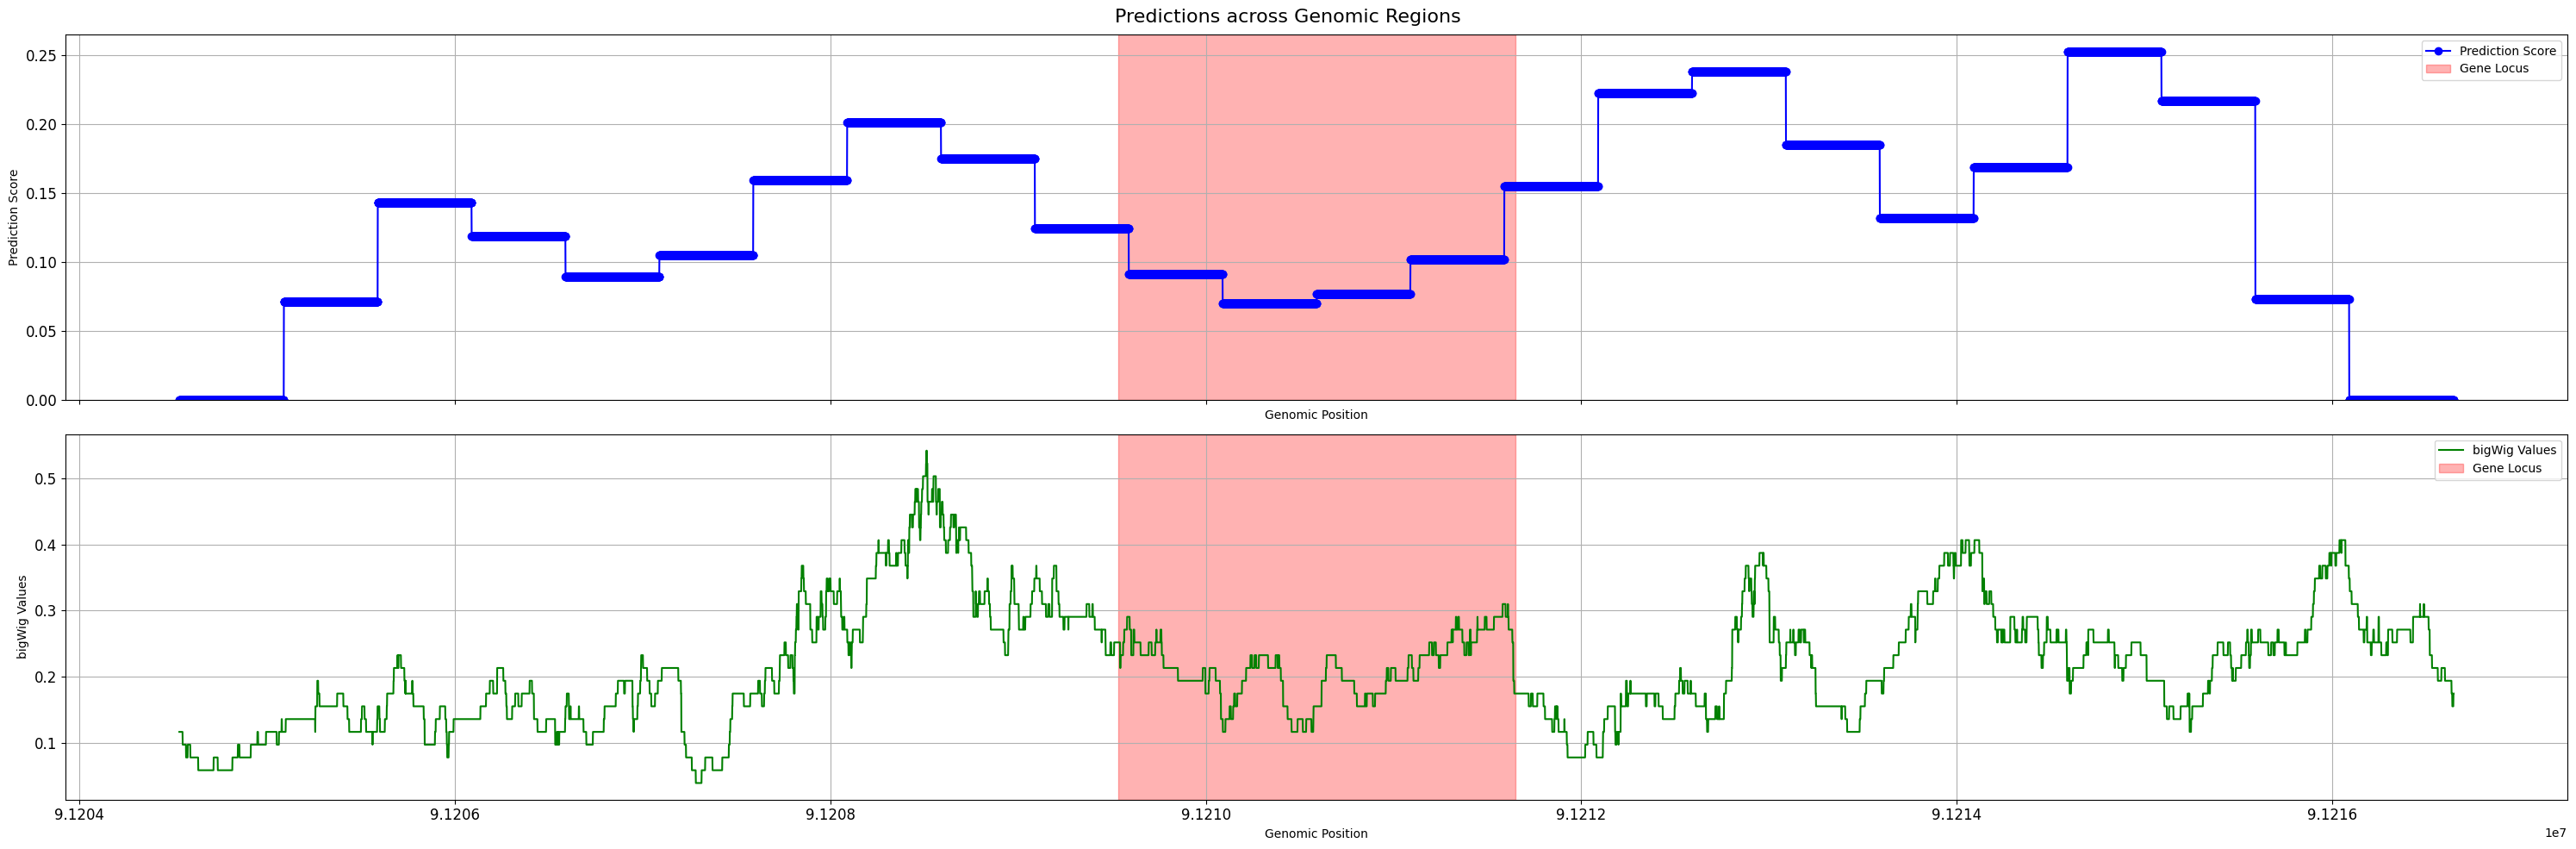

In [19]:
%matplotlib inline
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    height=10,
    width=30,
)

In [20]:
crested.pp.sort_and_filter_regions_on_specificity(adata, top_k=1000)

2024-11-19T14:23:53.784408+0100 INFO After sorting and filtering, kept 19000 regions.


In [21]:
adata.obs_names

Index(['Astro', 'Endo', 'L2_3IT', 'L5ET', 'L5IT', 'L5_6NP', 'L6CT', 'L6IT',
       'L6b', 'Lamp5', 'Micro_PVM', 'OPC', 'Oligo', 'Pvalb', 'Sncg', 'Sst',
       'SstChodl', 'VLMC', 'Vip'],
      dtype='object')

In [23]:
trainer.tfmodisco_calculate_and_save_contribution_scores(
    adata,
    output_dir="modisco_results",
    class_names=list(adata.obs_names),
    method="integrated_grad",
)

2024-11-19T14:24:23.844262+0100 INFO Found 'Class name' column in adata.var. Using specific regions per class to calculate contribution scores.
2024-11-19T14:24:23.913092+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:25:25.889243+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:26:26.770164+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:27:29.048447+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:28:31.376441+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:29:33.783807+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:30:36.176708+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:31:38.554615+0100 INFO Calculating contribution scores for 1 class(es) and 1000 region(s).
2024-11-19T14:32

In [24]:
crested.tl.modisco.tfmodisco(
    window=1000,
    output_dir="modisco_results",
    contrib_dir="modisco_results",
    report=False,
)

2024-11-19T14:45:38.812266+0100 INFO No class names provided, using all found in the contribution directory: ['Astro', 'Micro_PVM', 'L6IT', 'L2_3IT', 'Endo', 'L5ET', 'Oligo', 'OPC', 'L6CT', 'L5_6NP', 'VLMC', 'Pvalb', 'Sst', 'SstChodl', 'L5IT', 'L6b', 'Vip', 'Sncg', 'Lamp5']
Modisco results already exist for class: Astro
2024-11-19T14:45:39.694948+0100 INFO Running modisco for class: Micro_PVM
Using 5000 positive seqlets
Extracted 3953 negative seqlets
2024-11-19T14:54:24.312604+0100 INFO Running modisco for class: L6IT
Using 5000 positive seqlets
Extracted 1089 negative seqlets
2024-11-19T14:59:20.188632+0100 INFO Running modisco for class: L2_3IT
Using 5000 positive seqlets
Extracted 882 negative seqlets
2024-11-19T15:05:03.870196+0100 INFO Running modisco for class: Endo
Using 5000 positive seqlets
Extracted 2091 negative seqlets
2024-11-19T15:11:49.397714+0100 INFO Running modisco for class: L5ET
Using 4601 positive seqlets
Extracted 134 negative seqlets
2024-11-19T15:16:20.926111+0

In [1]:
%matplotlib inline
import crested

crested.pl.patterns.modisco_results(
    classes=["Astro"],
    contribution="positive",
    contribution_dir="modisco_results",
    num_seq=1000,
    y_max=0.15,
    viz="contrib",
)

2024-11-19T14:18:30.672153+0100 INFO Starting genomic contributions plot for classes: ['Astro']


In [2]:
# First we obtain the resulting modisco files per class
matched_files = crested.tl.modisco.match_h5_files_to_classes(
    contribution_dir="modisco_results", classes=["Astro"]
)

In [3]:
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=1.5,  # The similarity threshold used for matching patterns. We take the -log10(pval), pval obtained through TOMTOM matching from tangermeme
    trim_ic_threshold=0.1,  # Information content (IC) threshold on which to trim patterns
    discard_ic_threshold=0.2,  # IC threshold used for discarding single instance patterns
    verbose=True,  # Useful for doing sanity checks on matching patterns
)

Reading file modisco_results/Astro_modisco_results.h5
Match between Astro_neg_patterns_5 and Astro_neg_patterns_2 with similarity score 1.83
Match between Astro_pos_patterns_0 and Astro_neg_patterns_1 with similarity score 3.22
Match between Astro_pos_patterns_4 and Astro_pos_patterns_3 with similarity score 3.69
Match between Astro_pos_patterns_5 and Astro_pos_patterns_1 with similarity score 1.77
Match between Astro_pos_patterns_6 and Astro_neg_patterns_3 with similarity score 2.86
Match between Astro_pos_patterns_10 and Astro_pos_patterns_7 with similarity score 7.18
Match between Astro_pos_patterns_11 and Astro_pos_patterns_10 with similarity score 4.06
Match between Astro_pos_patterns_12 and Astro_pos_patterns_5 with similarity score 2.65
Match between Astro_pos_patterns_14 and Astro_pos_patterns_4 with similarity score 4.84
Merged patterns Astro_pos_patterns_2 and Astro_pos_patterns_10 with similarity 4.784636823321841
Iteration 1: Merging complete, checking again
Discarded 0 pat

In [4]:
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=["Astro"], all_patterns=all_patterns, normalize=True
)
pattern_matrix.shape

(1, 11)

In [5]:
pattern_matrix

array([[-1.        ,  1.        ,  0.00373562,  0.65631528, -0.37076766,
         0.60865278,  0.38728487,  0.56011301,  0.97703065,  0.58879881,
         0.56519941]])

In [7]:
import matplotlib

# Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

pat_seqs = crested.tl.modisco.generate_nucleotide_sequences(all_patterns)
crested.pl.patterns.clustermap(
    pattern_matrix,
    ["Astro"],
    ["Astro"],
    figsize=(20, 4.2),
    pat_seqs=pat_seqs,
    grid=True,
)

ValueError: The number of observations cannot be determined on an empty distance matrix.